# Solar Array Cost Prediction ML Model

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, make_scorer

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.svm import SVR

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor 

import scipy.stats as stats
import statsmodels.api as sm

import os
from pprint import pprint

import time

C:\Users\smouz\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
# OrdinalEncoder??

In [3]:
# format float in pandas
pd.options.display.float_format = '{:.4f}'.format
pd.options.display.max_columns = 30
pd.options.display.max_rows = 50
pd.options.display.width = 100

In [4]:
plt.style.use('seaborn-white')
rcParams['axes.labelsize'] = 'x-large'
rcParams['axes.edgecolor'] = 'black'
rcParams['axes.facecolor'] = 'white'
rcParams['axes.titlesize'] = 'x-large'
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.xmargin'] = 0.02
rcParams['axes.ymargin'] = 0.02
            
rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = ':'
rcParams['grid.alpha'] = 0.2
rcParams['grid.color'] = 'black'
          
rcParams['figure.titlesize'] = 'x-large'
rcParams['figure.edgecolor']= 'black'
rcParams['figure.facecolor'] = 'white'
rcParams['figure.figsize'] = [12, 8]

rcParams['ytick.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 'large'

In [5]:
os.getcwd()

'C:\\Users\\smouz\\Google Drive\\jupyter_notebook\\projects\\solar_array'

In [6]:
pv_df = pd.read_csv('pv_df_clean_2.csv', low_memory=False)
pv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612172 entries, 0 to 612171
Data columns (total 35 columns):
date_installed                 612172 non-null object
state                          612172 non-null object
incentive_prog_names           459717 non-null object
size_kw                        612172 non-null float64
zipcode                        612172 non-null int64
install_type                   612172 non-null object
installer                      401915 non-null object
cost_per_watt                  612168 non-null float64
cost                           612172 non-null float64
city                           461178 non-null object
utility_clean                  457662 non-null object
tech_1                         358820 non-null object
model1_clean                   358820 non-null object
county                         608230 non-null object
annual_pv_prod                 612172 non-null float64
annual_insolation              612167 non-null float64
rebate               

In [7]:
def drop_n_reset(df):
    '''
    axis = {0: rows, 1: columns}
    Drop row if all values are missing in that column,
    Drop row if all values are missing in that row, drop duplicates
    Reset index, drop original index
    '''
    df = df.dropna(axis=1, how='all') 
    df = df.dropna(axis=0, how='all').drop_duplicates()
    return df.reset_index(drop=True)

In [8]:
# remove missing rows where cost is missing
# pv_df[pv_df['cost'].isnull().values] = np.nan
pv_df = drop_n_reset(pv_df)
# pv_df.info()

In [9]:
# =============================================================================
# Convert to datetime
# =============================================================================
date_time = '%Y-%m-%d'
datetime = pd.to_datetime(pv_df['date_installed'], format=date_time)
clean_pv = pv_df.set_index(datetime).sort_index()

In [10]:
clean_pv = clean_pv['1998':'2017']
# clean_pv.info()

In [11]:
# clean_pv.info()

## Feature Engineering
### Combine Technology Type

Combine features which appear infrequently into a single group called '*other*'. This will reduce the size of the sparse matrix that will be created when categorical variables are encoded. Additionally, new features can be created from existing numeric and categoric features. 


In [12]:
def counts_of(array, df=clean_pv, count=True):
    if count:
        return df[array].value_counts()
    return df[array].value_counts() / np.count_nonzero(df[array].notnull()) * 100

In [13]:
# proportion of technology types
tech_counts = clean_pv['tech_1'].value_counts() / np.count_nonzero(clean_pv['tech_1'].notnull()) * 100
tech_counts

poly             58.6339
mono             38.3376
crystalline       1.5807
mono + a-si       1.0833
cigs              0.1633
cdte              0.1243
a-si              0.0399
a-si + micro-c    0.0139
thin film         0.0123
multiple          0.0095
cis               0.0014
Name: tech_1, dtype: float64

In [14]:
# combine technology types which appear infrequently into a single group called 'other'
tech_counts[tech_counts < 38].index

Index(['crystalline', 'mono + a-si', 'cigs', 'cdte', 'a-si', 'a-si + micro-c', 'thin film',
       'multiple', 'cis'],
      dtype='object')

In [15]:
mask = clean_pv['tech_1'].isin(tech_counts[tech_counts < 38].index)
clean_pv['tech_1'][mask] = 'others'

### Combine Variables: *tech_1*
Reduce the amount of variables in the column

In [16]:
clean_pv['tech_1'].value_counts()

poly      210390
mono      137563
others     10867
Name: tech_1, dtype: int64

In [17]:
clean_pv.groupby('tech_1')['cost'].mean()

tech_1
mono     29433.8384
others   32187.3851
poly     28387.4800
Name: cost, dtype: float64

In [18]:
def combine_features(feature, threshold, df=clean_pv, new_tag='others'):
    state_count = counts_of(feature)
    mask = clean_pv[feature].isin(state_count[state_count < threshold].index)
    clean_pv[feature][mask] = new_tag

### Combine Variables: *tracking_type*

In [19]:
counts_of('tracking_type')

fixed          327876
single-axis       467
dual-axis         363
mixed             253
Name: tracking_type, dtype: int64

In [20]:
combine_features('tracking_type', 500, new_tag='has_axis')
counts_of('tracking_type')

fixed       327876
has_axis      1083
Name: tracking_type, dtype: int64

In [21]:
# clean_pv.select_dtypes(include='object').sample(5)

## Scaling

In [22]:
# RobustScaler().fit_transform(state['annual_insolation'].dropna())

# state = clean_pv[clean_pv.state == 'ca']
# t = 1
# sns.distplot(clean_pv['annual_insolation'].dropna()**(t))
# sns.distplot(clean_pv['cost'].dropna()**(t))
# sns.distplot(clean_pv['size_kw'].dropna()**(t))

# sns.distplot(clean_pv['cost'].dropna()**(t))

# plt.show()

In [23]:
# t = 1/2
# t=1
# scaled_df = pd.DataFrame()
# scaled_df['insolation_RB'] = np.arange(len(clean_pv))
# scaler = StandardScaler()
# pow_tx = PowerTransformer()
# quant_tx = QuantileTransformer(n_quantiles=1000, output_distribution='normal')

# def transform_variable(feature, df=clean_pv):
#     power_transform = pow_tx.fit_transform((clean_pv[[feature]]).fillna(clean_pv[feature].mean()))
#     standard_scaler = scaler.fit_transform((clean_pv[[feature]]**t).fillna(clean_pv[feature].mean()))
#     quantile_transform = quant_tx.fit_transform((clean_pv[[feature]]).fillna(clean_pv[feature].mean()))
#     return power_transform, standard_scaler, quantile_transform


In [24]:
# sns.distplot(scaled_df['insolation'])
# sns.distplot(scaled_df['cost'])
# sns.distplot(scaled_df['size'])

# power_tx, stand, qnt_tx = transform_variable(feature='cost')

# sns.distplot(MinMaxScaler().fit_transform(stand))
# sns.distplot(stand)
# sns.distplot(power_tx)
# sns.distplot(qnt_tx)
# plt.legend(('power', 'square root', 'quantile'))
# plt.show()

In [25]:
# stats.probplot(qnt_tx.ravel(), dist="norm", plot=plt)
# plt.show()

# stats.probplot(qnt_tx.ravel(), dist="norm", plot=plt)
# plt.show()

## Missing Values

In [26]:
def percent_missing(df, threshold=50, drop=False):
    """
    Calculate percent missing values in each column.
    
    Returns a series showing the proportion of missing vals in each column
    
    Drop columns which contain more than <threshold> missing values.
    """
    ms = (np.sum(df.isnull()) / len(df)) * 100
    if drop:
        return df.drop(labels=ms[ms >= threshold].index, axis=1)     
    else:
        return ms.sort_values()

In [27]:
percent_missing(clean_pv)

date_installed                 0.0000
year                           0.0000
day                            0.0000
month                          0.0000
size_catg                      0.0000
total_cost                     0.0000
3rdparty                       0.0000
cost_mo_agg_med                0.0000
annual_pv_prod                 0.0000
month_install_cnt              0.0000
state                          0.0000
cost                           0.0000
size_kw                        0.0000
zipcode                        0.0000
install_type                   0.0000
cost_per_watt                  0.0007
annual_insolation              0.0008
power_density                  0.0008
area_est                       0.0008
county                         0.6432
incentive_count                0.7566
city                          24.6531
incentive_prog_names          24.8917
utility_clean                 25.2274
installer                     34.3353
model1_clean                  41.3762
tech_1      

In [28]:
# NOTE:
# - December is cheaper apparently, but the difference between MIN and MAX doesn't seem significant enough
#   for making predictions

# (pv_dm['cost_mo_agg_med'] / pv_dm['month_install_cnt']).describe()
# clean_pv.groupby('month')['cost'].mean().sort_values()

In [29]:
# NOTE:
# - not a good predictor of cost
clean_pv.groupby('tracking_type')['cost'].median()
# pv_dm['tracking_type'].value_counts()

tracking_type
fixed      27700.0000
has_axis   26705.2200
Name: cost, dtype: float64

In [30]:
# clean_pv.groupby('zipcode')['cost'].median()
clean_pv['county'].nunique()

743

In [31]:
pv_dm = clean_pv.copy()

In [32]:
# print(pv_dm.columns.to_list()[:5])
# pv_dm.values[:, 1][:5]

list(pv_dm.columns).index('size_kw')

3

In [33]:
def process_data(df, to_drop=['date_installed', 'total_cost', '3rdparty', 'incentive_prog_names', 'zipcode',
                              'install_type', 'installer', 'city', 'utility_clean', 'model1_clean', 'tilt1',]):
    try:
        df = clean_pv.copy()
        df['rebate_per_kwh'] = df['rebate'] / df['annual_pv_prod']
        # drop missing values over 50%
        df = percent_missing(df, 50, drop=True)
        # drop features
        df = df.drop(to_drop, axis=1)

        # create new features
        df['cost_per_area'] = df['cost'] / df['area_est']
        df['cost_per_kwh'] = df['cost'] / df['annual_pv_prod']
        
        # adjust dtype
        df['month'] = df['month'].astype('category')
        df['day'] = df['day'].astype('category')
        df['year'] = df['year'].astype('category')
        
        # FREQUENCIES
        # month frequency
        month_freq = df['month'].value_counts()/len(df)
        df['month_freq'] = df['month'].map(month_freq)

        # month frequency
        county_freq = df['county'].value_counts()/len(df)
        df['county_freq'] = df['county'].map(county_freq)
        
        # state frequency, scaled
        state_freq = (df['state'].value_counts() / len(df))
        state_fr_scaled = ((np.log(1/(state_freq))) * state_freq) *100
        df['state_fr_scaled'] = df['state'].map(state_fr_scaled)
        
        # technology type
        tech_freq = df['tech_1'].value_counts()/len(df)
        df['tech_freq'] = df['tech_1'].map(tech_freq)
                
        # AGGREGATE
        # monthly cost aggregate / monthly installation count
        df['cost_per_install'] = df['cost_mo_agg_med']/df['month_install_cnt']

    except Exception as e:
        print('Something went wrong')
        print(e)
        pass
    return df

In [34]:
pv_dm = process_data(pv_dm)

In [35]:
# state_fr_scaled = ((np.log(1/(state_freq))) * state_freq) *100
# pv_dm['state_fr_scaled'] = pv_dm['state'].map(state_fr_scaled)
# state_fr_scaled[:15]

In [36]:
# state_freq = (pv_dm['state'].value_counts() / len(pv_dm))**(1/2)
# state_freq[:15]

### Train-Test Split

In [37]:
def train_test_split(df_train, df_test, target='cost'):
    """
    Returns arrays of X, y train and test sets
    Exclude additional features with param `drop_features` from predictors arrays
    
    Parameters:
    -----------
        df_train:      training set
        df_test:       testing set
        target:        target variable
        drop_features: drop additional features from df
    
    Returns:
    -----------
        X_train, X_test, y_train, y_test
    """
    X_train = df_train.drop(target, axis=1)
    X_test = df_test.drop(target, axis=1)
    y_train = df_train[[target]]
    y_test = df_test[[target]]
    return X_train, y_train, X_test, y_test
    
def drop_features(df_train, df_test, drop):
    df_train = df_train.drop(drop, axis=1)
    df_test = df_test.drop(drop, axis=1)
    return df_train, df_test

def train_test_df(df, end_date, start_date, show_split=False):
    """
    Split dataframe into Training and Testing set by dates.
    
    Training set will be past data, from start to `split_date`.
    
    Testing set will more future data, from `split_date` to end.
    
    The goal is to have about 80/20 split.
    """
    train_set = df.loc[:end_date, :]
    test_set = df.loc[start_date:, :]
    if show_split:
        # return split proportion of TRAIN, TEST
        return len(train_set)/len(df), len(test_set)/len(df)
    return train_set, test_set

# select numeric dtype 
def get_numeric_data(df):
    return df.select_dtypes(include=np.float64)

# select categoric dtype 
def get_non_numeric_data(df):
    return df.select_dtypes(exclude=np.float64)


In [38]:
# categorical columns

# train_set, test_set = train_test_df(pv_dm, '2015-05-31', '2015-06-01', show_split=False)
# train_set.columns
# get_non_numeric_data(train_set).columns.to_list()

In [39]:
# train_set, test_set = train_test_df(pv_dm, '2015-05-31', '2015-06-01')

# drop = ['state', 'size_catg', 'cost_per_watt', ]
# train_set, test_set = drop_features(train_set, test_set, drop=drop)

# X_train, X_test, y_train, y_test = train_test_split(train_set,
#                                                     test_set,
#                                                     'cost'
#                                                    )
# X_train.shape

## Multilinear Regression

In [40]:
def model_metrics(model, X_train, y_train, X_test, y_test, y_pred):
    print('Metrics:')
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  
    print('Train set R^2 score:       ', model.score(X_train, y_train))
    print('Test set R^2 score:        ', model.score(X_test, y_test))   
    print('Mean absolute error:       ', mean_absolute_error(y_test, y_pred))
    print('RMSE on test set:          ', rmse)
    print('='*50)
    
def coeff_table(estimator, dropped = ['cost']):
    print('Coefficients:')
    coef_df = pd.DataFrame(estimator.coef_, columns=[train_set.drop(dropped, axis=1).columns]).transpose()
    return coef_df[0].sort_values()

def to_coeff_table(data, index):
    print('Coefficients:')
    return pd.Series(data, index).sort_values()


## Regression Pipeline

### ColumnTransformer
Combines transformer for two different types of features (different dtypes).

In [41]:
# pv_dm = process_data(clean_pv.copy())

In [42]:
pv_dm.sample(5)

,state,size_kw,cost_per_watt,cost,tech_1,county,annual_pv_prod,annual_insolation,tracking_type,incentive_count,area_est,power_density,size_catg,month,day,year,cost_mo_agg_med,month_install_cnt,cost_per_area,cost_per_kwh,month_freq,county_freq,state_fr_scaled,tech_freq,cost_per_install
date_installed,,,,,,,,,,,,,,,,,,,,,,,,,
2012-12-17,ca,5.2800,6540.0000,34556.0000,NaN,los angeles,8071.9908,2267.1043,NaN,62.0000,26.3740,0.2002,normal,12,17,2012,26268.0000,4771,1310.2316,4.2810,0.1121,0.0969,31.3057,nan,5.5058
2010-07-02,ca,3.5840,6525.5804,23387.6800,poly,lake,5388.8223,1989.5119,fixed,55.0000,20.0638,0.1786,small,7,2,2010,31655.1500,2690,1165.6645,4.3400,0.0867,0.0014,31.3057,0.3437,11.7677
2010-07-20,nj,6.4500,7450.0000,48053.0000,NaN,ocean,9860.6706,1811.1512,NaN,37.0000,40.3290,0.1599,large,7,20,2010,46334.0000,320,1191.5233,4.8732,0.0867,0.0014,4.5829,nan,144.7937
2012-04-25,ca,3.2250,5210.0000,16802.2500,poly,los angeles,5026.4944,2046.6270,fixed,62.0000,18.1925,0.1773,small,4,25,2012,27000.0000,4140,923.5804,3.3427,0.0681,0.0969,31.3057,0.3437,6.5217
2012-12-27,ca,1.8400,4608.1522,8479.0000,mono,los angeles,2892.7498,2029.6276,NaN,62.0000,10.5575,0.1743,small,12,27,2012,26268.0000,4771,803.1264,2.9311,0.1121,0.0969,31.3057,0.2247,5.5058


In [43]:
percent_missing(pv_dm)

state                0.0000
state_fr_scaled      0.0000
month_freq           0.0000
cost_per_kwh         0.0000
month_install_cnt    0.0000
cost_mo_agg_med      0.0000
year                 0.0000
day                  0.0000
month                0.0000
size_catg            0.0000
annual_pv_prod       0.0000
cost                 0.0000
size_kw              0.0000
cost_per_install     0.0000
cost_per_watt        0.0007
area_est             0.0008
power_density        0.0008
annual_insolation    0.0008
cost_per_area        0.0008
county               0.6432
county_freq          0.6432
incentive_count      0.7566
tech_freq           41.3762
tech_1              41.3762
tracking_type       46.2549
dtype: float64

### Function: feed_data()

In [44]:
# drop_features = ['state', 'size_catg', 'cost_per_watt', 'size_kw', 'annual_insolation','incentive_count']
def feed_data(train_set, test_set, to_drop=['state', 'county', 'size_catg', 
                                            'day', 
                                            'year',
                                            'month', 
                                            'cost_per_watt', 
                                            'size_kw',
#                                             'annual_insolation', 
                                            'incentive_count',
#                                             'annual_pv_prod',
                                            'cost_per_install',
                                            'month_install_cnt', 'cost_mo_agg_med',  
#                                             'cost_per_area',
#                                             'cost_per_kwh',
                                            'month_freq',
#                                             'county_freq', 
                                            'tech_freq',
                                            'state_fr_scaled',
                                            'tech_1', 
                                            'tracking_type',
                                           ]): 
    """
    Drops additional features, and returns train/test split matrices, 
    and dataframe.
    
    How to use:
    -----------
    Unpack results into temporary variable, then assigned new variables 
    by indexing the temporary variable.
        Example:
        --------
        temp = feed_data(train_set=train_, test_set=test_)
        X_train, y_train, X_test, y_test = temp[0]
        train_df = temp[1]
        test_df = temp[2]
    
    Returns:
    --------
    Returns a tuple of train and test set split and additionally the 
    modified train and test dataframe.
    `tuple(X_train, y_train, X_test, y_test), train, test`
    """
    train, test = drop_features(df_train=train_set, df_test=test_set, drop=to_drop)
    # returns: 
    #    X_train, y_train, X_test, y_test
    return train_test_split(df_train=train,df_test=test, target='cost'), train, test


### Function: build_pipeline()
Regression Pipeline 

In [51]:
def build_pipeline(regressor, data=pv_dm, poly_degree=0, impute_strategy='mean', k_select=5, model_only=False, split_only=False, coef=False, **kwargs):
    """
    Reuse pipeline to test various regression algorithms.
    
    Process numeric and categoric features seperately.
    
    """
    train_, test_ = train_test_df(data, '2015-05-31', '2015-06-01')

    # define train and test samples
    # unpack into a temporary variable
    temp = feed_data(train_set=train_, test_set=test_)
    X_train, y_train, X_test, y_test = temp[0]
    train_ = temp[1]
    test_ = temp[2]
    
#     print('Features:', X_train.columns.to_list())
    if split_only:
        return X_train, y_train, X_test, y_test
    
    # Pipeline 1: preprocess numeric data
    numeric_features = X_train.dtypes == 'float'
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', QuantileTransformer(output_distribution='normal')),      
    ])  

    # Pipeline 2: preprocess categorical features, if any
    categorical_features = ~numeric_features
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ])

    # COLUMN TRASNFORMER
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ], n_jobs=-1
    )
   
    # MODEL PIPELINE
    steps = [
        ('preprocessor', preprocessor),
        ('feature select', SelectKBest(f_regression, k=k_select)),
        ('regressor', regressor(**kwargs)
        )]
    
    model = Pipeline(steps)
    
    if poly_degree > 0:
        # add step into pipeline when called for polynomials
        print('Degree:', poly_degree)    
        steps.insert(2,
                     ('polynomial features', PolynomialFeatures(degree=poly_degree,
                                                                include_bias=False))
                    )
        
    if model_only:
        return model

#     pprint(model.named_steps['regressor'].get_params())
    fit_start = time.time()
    y_pred = model.fit(X_train, y_train.values.ravel()).predict(X_test)
    print('Fit time:', time.time() - fit_start)
    model_metrics(model, X_train, y_train, X_test, y_test, y_pred)
    if coef:
        pd.Series(X_train.columns, model.named_steps['regressor'].coef_)
        return model
    return model

## RidgeCV: Hyperparameters
Higher alpha will penalize the coefficients more significantly and may lead to underfitting as the coefficients will become too small. Coefficients that are too small will underfit the data because the model will be too simple. An alpha of zero will result with the OLS loss function with zero regularization

In [46]:
# mse = make_scorer(mean_squared_error, greater_is_better=False)
mse_list = []

# Start with a 1-4 range, and increment
for i in np.arange(3,6):
#     print(i, "-", i+3)
    print(np.mean([1,i+3]))

3.5
4.0
4.5


In [47]:
# for i in np.arange(4,8):
#     print('Trying range...', i, "-", i+3)
#     alpha_space = np.logspace(i, i+3, 100)
#     ridge_cv = build_pipeline(regressor=linear_model.RidgeCV, cv=3, scoring=mse, alphas=alpha_space, k_select=5)
#     mse_list.append(ridge_cv.named_steps['regressor'].alpha_)
# mse_list

In [48]:
# alpha_space = np.logspace(4.75, 4.9, 20)
# ridge_cv = build_pipeline(regressor=linear_model.RidgeCV, cv=5, scoring=mse, alphas=alpha_space, k_select=5)
# ridge_cv.named_steps['regressor'].alpha_

In [48]:
# 0.1233, 0.4520, 0.0464, 15.85, 8697, 56234.13, 89449.71
ridge = build_pipeline(regressor=linear_model.Ridge, alpha=89449.71, k_select='all', random_state=11, coef=True)
# ridge.named_steps['regressor'].coef_

Fit time: 3.6657614707946777
Metrics:
Train set R^2 score:        0.9200972158306708
Test set R^2 score:         0.9283698743271784
Mean absolute error:        2348.030073264288
RMSE on test set:           3203.8016707297456


In [47]:
# 0.1233, 0.4520, 0.0464, 15.85, 8697
ridge = build_pipeline(regressor=linear_model.Ridge, alpha=8697, k_select=6, random_state=11)
ridge.named_steps['regressor'].coef_

Fit time: 4.349189043045044
Metrics:
Train set R^2 score:        0.9363092125449355
Test set R^2 score:         0.9188513060068961
Mean absolute error:        2250.3789823389243
RMSE on test set:           3410.0326269382376


array([5.54886918e+03, 2.77395408e+02, 7.60102244e+03, 4.42314387e+03,
       4.34144878e+03, 5.15525983e+00])

## Ridge Poly

In [52]:
# 0.1233, 0.4520, 0.0464, 8697, 129.1550
ridge_poly = build_pipeline(regressor=linear_model.Ridge,
                            poly_degree=3, 
                            alpha=129.1550, 
                            k_select=5, 
                            random_state=11, 
#                             data=pv_dm.sample(200000)
                           )
# ridge_poly.named_steps['regressor'].coef_

Degree: 3
Fit time: 4.938671827316284
Metrics:
Train set R^2 score:        0.9980923369722384
Test set R^2 score:         0.9966929945150184
Mean absolute error:        400.26050262481533
RMSE on test set:           688.3910647382899


In [56]:
print(ridge_poly.named_steps['regressor'].coef_.max())
print(ridge_poly.named_steps['regressor'].coef_.mean())
print(ridge_poly.named_steps['regressor'].coef_.min())
print(ridge_poly.named_steps['regressor'].coef_.std())
# print(ridge_poly.named_steps['regressor'].coef_)

10468.164378512622
589.4504279748796
-1433.5404294349446
1788.4769901222523


## LassoCV

In [89]:
alpha_space = np.logspace(-1, 3, 100)
lasso_cv = build_pipeline(regressor=linear_model.LassoCV, cv=5, alphas=alpha_space, n_jobs=-1, poly_degree=2, max_iter=2000)

Features: ['annual_pv_prod', 'annual_insolation', 'area_est', 'power_density', 'cost_per_area', 'cost_per_kwh', 'month_freq', 'county_freq']
Degree: 2


C:\Users\smouz\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\smouz\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\smouz\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fit time: 21.59193754196167
Metrics:
Train set R^2 score:        0.9923389079249749
Test set R^2 score:         0.9871980027474586
Mean absolute error:        818.1729921719539
RMSE on test set:           1354.4302094674656


In [90]:
lasso_cv.named_steps['regressor'].alpha_

0.2782559402207124

### Lasso Poly: Degree=4, Long fit time

In [95]:
# lasso_poly = build_pipeline(regressor=linear_model.Lasso, alpha=0.002, max_iter=3000)

## Kernel Ridge

In [57]:
# krr = build_pipeline(KernelRidge, alpha=0.021, kernel='rbf', degree=3, gamma=0.3, k_select=5, data=pv_dm.sample(25000))

Fit time: 58.488086462020874
Metrics:
Train set R^2 score:        0.9998533144067274
Test set R^2 score:         0.9961932115025559
Mean absolute error:        161.34679806130075
RMSE on test set:           751.8106852852436


In [116]:
# krr = build_pipeline(KernelRidge, alpha=0.0015, kernel='rbf', degree=3, gamma=0.3, k_select=5, data=pv_dm.sample(20000))

Features: ['annual_pv_prod', 'annual_insolation', 'area_est', 'power_density', 'cost_per_area', 'cost_per_kwh', 'state_fr_scaled', 'tech_freq']
Fit time: 31.085333585739136
Metrics:
Train set R^2 score:        0.9999380800587073
Test set R^2 score:         0.997741313720552
Mean absolute error:        116.4557163587816
RMSE on test set:           571.0792375552674


In [94]:
# KernelRidge??

## SGDRegressor

In [50]:
# alpha: 0.1
sgd = build_pipeline(regressor=linear_model.SGDRegressor, 
                     loss='squared_epsilon_insensitive', 
                     alpha=0.015,
                     l1_ratio=0.15,
                     epsilon=0.01,
                     max_iter=10,
                     poly_degree=2,
                     k_select=5,
                     random_state=11)

Features: ['annual_pv_prod', 'annual_insolation', 'area_est', 'power_density', 'cost_per_area', 'cost_per_kwh', 'state_fr_scaled', 'tech_freq']
Degree: 2


C:\Users\smouz\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Fit time: 3.326791524887085
Metrics:
Train set R^2 score:        0.9919945162394004
Test set R^2 score:         0.9856227906334356
Mean absolute error:        812.9578702068746
RMSE on test set:           1435.3409175340194


## GridSearch Hyperparameters

In [1]:
# alpha=129.1550, 89449.71
# ridge_poly = build_pipeline(regressor=linear_model.Ridge, alpha=89449.71, k_select=5, random_state=11, data=pv_dm.sample(100000))

In [58]:
ridge_poly = build_pipeline(regressor=linear_model.Ridge, poly_degree=2, alpha=26, k_select=5, random_state=11, data=pv_dm.sample(200000))

mse = make_scorer(mean_squared_error, greater_is_better=False)
ridge_params = {}
# ridge_params['regressor__alpha'] = [26, 28.5714, 183]
ridge_params['regressor__alpha'] = [28.5714]
ridge_params['polynomial features__degree'] = [4,5]
# ridge_params['feature select__k'] = [5]

X_train, y_train, X_test, y_test = build_pipeline(linear_model.Ridge, split_only=True, data=pv_dm.sample(200000))
search_cv = RandomizedSearchCV(
    ridge_poly,
    ridge_params,
    scoring=mse,
    n_jobs=-1,
    cv=3,
    random_state=11
)
search_cv.fit(X_train, y_train)
print('Best RMSE:', np.sqrt((-1*(search_cv.best_score_))))
print('Best params:', search_cv.best_params_)

Degree: 2
Fit time: 0.8637833595275879
Metrics:
Train set R^2 score:        0.9926213822755944
Test set R^2 score:         0.9878711061079226
Mean absolute error:        804.9855815523558
RMSE on test set:           1329.2000576943792


C:\Users\smouz\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\smouz\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best RMSE: 424.64457016479474
Best params: {'regressor__alpha': 28.5714, 'polynomial features__degree': 5}


In [59]:
build_pipeline(regressor=linear_model.Ridge,
               poly_degree=search_cv.best_params_['polynomial features__degree'], 
               alpha=search_cv.best_params_['regressor__alpha'], 
#                k_select=search_cv.best_params_['feature select__k'], 
               random_state=11, 
               data=pv_dm.sample(200000))

Degree: 5
Fit time: 4.965516567230225
Metrics:
Train set R^2 score:        0.9993189997369007
Test set R^2 score:         0.9975089468355831
Mean absolute error:        249.39505523454716
RMSE on test set:           592.7213202642185


Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=-1, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0... fit_intercept=True, max_iter=None,
   normalize=False, random_state=11, solver='auto', tol=0.001))])

# Model Validation

In [56]:
# function for validation
def validate_results(model, X_test, y_test, scoring=mse, cv=10, n_jobs=-1, **kwargs):
    return cross_val_score(model, X_test, y_test, scoring=mse, cv=cv, n_jobs=n_jobs, **kwargs)

In [58]:
# RIDGE VALIDATION
# np.sqrt(mean_squared_error(y_test, y_pred)) 
     
ridge_poly_best = build_pipeline(
    regressor=linear_model.Ridge,
    poly_degree=search_cv.best_params_['polynomial features__degree'], 
    alpha=search_cv.best_params_['regressor__alpha'], 
#     k_select=search_cv.best_params_['feature select__k'], 
    random_state=11, 
    data=pv_dm.sample(100000)
)

X_train, y_train, X_test, y_test = build_pipeline(regressor=linear_model.Ridge, alpha=8697, poly_degree=4, k_select=4, split_only=True)
cv_results = validate_results(ridge_poly_best, X_test, y_test, cv=5)

Fit time: 1.313155174255371
Degree: 5
Metrics:
Train set R^2 score:        0.999219039368013
Test set R^2 score:         0.9893889531109623
Mean absolute error:        295.593234373473
RMSE on test set:           1231.1741491129787


MemoryError: Unable to allocate array with shape (4, 105312) and data type float64

In [59]:
print('RMSE scores:', np.sqrt((cv_results*-1)))
print('RMSE mean:', np.mean(np.sqrt((cv_results*-1))))
print('RMSE std:', np.std(np.sqrt((cv_results*-1))))

NameError: name 'cv_results' is not defined

## Statsmodels API

In [ ]:
# # manually add intercept term to X_train
# X_train = np.append(X_train, np.ones((len(X_train), 1)), axis=1)
# # X_test = np.append(X_test, np.ones((len(X_test), 1)), axis=1)

# # fit and summarize results
# ols = sm.OLS(y_train, X_train)
# results = ols.fit()
# results.summary()

# # print(train_set.drop(columns='cost').columns.values)
# # results.summary2()
# sns.scatterplot(x=results.resid, y=results.fittedvalues)
# plt.show()

## Plot RMSE vs. Hyperparameter

In [55]:
# plot RMSE vs a single hyperparameter of some estimator

def plot_rmse(estimator, value_name, test_values, degree=2, plot=False, **kwargs):
    rmse_ls = []
    r2_score_ls = []
    # Compute scores over range of alphas
    for i in test_values:

        X_train, y_train, X_test, y_test = build_pipeline(regressor=estimator,
                                                          k_select=5,
                                                          split_only=True,
                                                          data=pv_dm.sample(200000)
                                                         )
        pipeline = build_pipeline(regressor=estimator,
                                  poly_degree=degree,
                                  alpha=i,
                                  k_select=5,
                                  model_only=True,
                                  data=pv_dm.sample(200000)
                                 )

        y_pred = pipeline.fit(X_train, y_train.values.ravel()).predict(X_test)
        rmse_ls.append(np.sqrt(mean_squared_error(y_test.values.ravel(), y_pred)))
        r2_score_ls.append(r2_score(y_test, y_pred))

    df_rmse = pd.DataFrame({'rmse': rmse_ls,
                            'test_values': test_values,
                            'r2_score': r2_score_ls
                           })
    if plot:
        plt.scatter(x = df_rmse.test_values, y = df_rmse.rmse, alpha=0.5, marker='.')
        plt.xscale('log')
#         plt.ylim([df_rmse.root_mean.min()-100, df_rmse.root_mean.max()+100])
#         plt.xlim([df_rmse.test_values.min(), df_rmse.test_values.max()])
        plt.title(f'RMSE for {value_name.capitalize()}\n{str(estimator)}')
        plt.xlabel('Value')
        plt.ylabel('RMSE')
        plt.show()
#     return df_rmse[df_rmse['root_mean'] == df_rmse['root_mean'].min()]['test_values']
    return df_rmse.sort_values(by='rmse')

## Ridge Regression Plot

In [51]:
np.linspace(25, 30, 8)

array([25.        , 25.71428571, 26.42857143, 27.14285714, 27.85714286,
       28.57142857, 29.28571429, 30.        ])

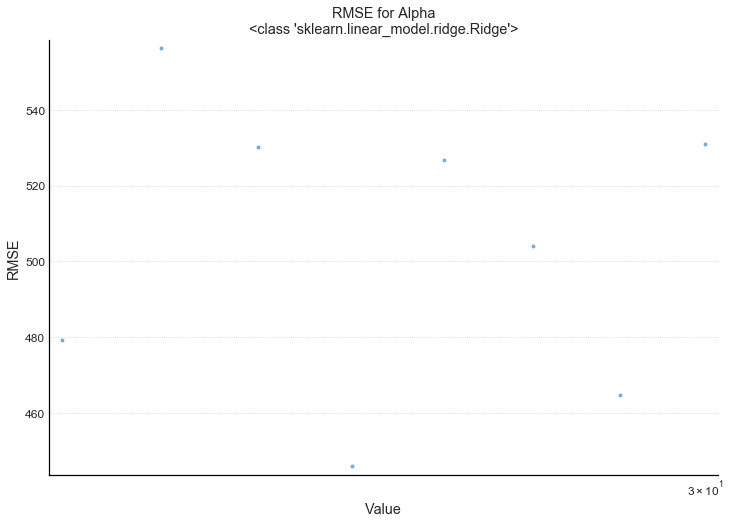

In [64]:
# Ridge Regression Plot
# np.logspace(1, 2, 20)
alpha_space = np.linspace(25, 30, 8)
alpha_df = plot_rmse(
    estimator=linear_model.Ridge,
    value_name = 'alpha',
    test_values = alpha_space,
    degree=4,
    plot=True
)

In [65]:
# ridge regressor
# print('alpha value:', alpha.values)
# build_model(linear_model.Ridge, alpha=alpha.values)
alpha_df

,rmse,test_values,r2_score
3,445.9045,27.1429,0.9986
6,464.7697,29.2857,0.9985
0,479.3381,25.0000,0.9984
5,504.0898,28.5714,0.9982
4,526.7068,27.8571,0.9981
2,530.3285,26.4286,0.9980
7,530.9320,30.0000,0.9980
1,556.3523,25.7143,0.9978


## Polynomial Regression 
Using Polynomial Features with varying degrees create additional features and evaluate model.

In [158]:

# list degrees to test
degrees = np.arange(1,6)
# initialize lists to collect variables
train_score = []
test_score = []

ridge = build_pipeline(regressor=linear_model.Ridge, alpha=0.1233, poly_degree=2, k_select=5)

# for degree in range(degree_min,degree_max+1):
#     <insert pipeline here>

#     predicted = model.fit(X_train,y_train).predict(X_test)
# #     print('\n','='*50)
#     print('Degree:              ', degree)
#     print('RMSE:                ', np.sqrt(mean_squared_error(y_test, predicted)))
#     print('Test set R-sq score: ', model.score(X_test, y_test))
#     print('\n','='*50)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.0001, fit_intercept=True,
    max_iter=5000, n_alphas=20, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

## Random Forest Regression

In [163]:
rf = build_pipeline(regressor=RandomForestRegressor, n_estimators=30, k_select=5, n_jobs=-1)

Features: ['cost_per_watt', 'annual_pv_prod', 'area_est', 'power_density', 'cost_per_area', 'cost_per_kwh']
Fit time: 11.347333431243896
Metrics:
Train set R^2 score:        0.9999956242015687
Test set R^2 score:         0.9999583678541525
Mean absolute error:        31.75319566260615
RMSE on test set:           77.23820372273998


In [162]:
rf = build_pipeline(regressor=RandomForestRegressor, n_estimators=29, n_jobs=-1)

Features: ['cost_per_watt', 'annual_pv_prod', 'area_est', 'power_density', 'cost_per_area', 'cost_per_kwh']
Fit time: 10.157321214675903
Metrics:
Train set R^2 score:        0.9999954631229989
Test set R^2 score:         0.9999570605734821
Mean absolute error:        32.67714469674132
RMSE on test set:           78.44149946170401


In [88]:
# rf.named_steps['randomforestregressor'].feature_importances_

In [ ]:
# # Print how important each column is to the model
# for i, item in enumerate(rf.feature_importances_):
#       # Use i and item to print out the feature importance of each column
#     print("{0:s}: {1:.2f}".format(X_train.columns[i], item))